# Demo 05 - Cohort Analysis

At this point, we are building up suspicious about vendor 5.  They've submitted a huge number of invoices it seems, but we want to make this a stronger case by showing just how unusual their behavior is compared to everyone else.  This is where cohort analysis comes into play.

The key idea behind cohort analysis is to try to understand the behavior of one slice of the data given other slices.  In our example, we want to understand vendor 5's behavior with respect to the other vendors, or one employee's results in the context of other employees.  This makes it easier to observe differences and ask the right sorts of questions.

In [1]:
if(!require(tidyverse)) {
    install.packages("tidyverse", repos = "http://cran.us.r-project.org")
    library(tidyverse)
}

if(!require(odbc)) {
    install.packages("odbc", repos = "http://cran.us.r-project.org")
    library(odbc)
}

# ggplot2 is installed with the tidyverse.
library(ggplot2)

Loading required package: tidyverse
Warning message:
"package 'tidyverse' was built under R version 3.5.2"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.5.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: odbc
Warning message:
"package 'odbc' was built under R version 3.5.3"

Our primary data set will be the set of line items.  To make analysis easier I will join to the relevant lookup tables up-front.

In [2]:
conn <- DBI::dbConnect(odbc::odbc(), 
                      Driver = "SQL Server", 
                      Server = "localhost", 
                      Database = "ForensicAccounting", 
                      Trusted_Connection = "True")

In [3]:
lineItems <- DBI::dbGetQuery(conn, "SELECT
	li.LineItemID,
	li.BusID,
	li.VendorID,
	v.VendorName,
	li.ExpenseCategoryID,
	ec.ExpenseCategory,
	li.EmployeeID,
	e.FirstName,
	e.LastName,
	CONCAT(e.FirstName, ' ', e.LastName) AS EmployeeName,
	li.LineItemDate,
	c.CalendarMonth,
	c.MonthName,
	c.CalendarYear,
	c.FirstDayOfMonth,
	li.Amount
FROM dbo.LineItem li
	INNER JOIN dbo.Employee e
		ON li.EmployeeID = e.EmployeeID
	INNER JOIN dbo.ExpenseCategory ec
		ON li.ExpenseCategoryID = ec.ExpenseCategoryID
	INNER JOIN dbo.Vendor v
		ON li.VendorID = v.VendorID
	INNER JOIN dbo.Calendar c
		ON li.LineItemDate = c.Date;
")
lineItems$FirstDayOfMonth <- lubridate::ymd(lineItems$FirstDayOfMonth)

## A Gentle Reminder of the Issue

We want to investigate the dramatic uptick in invoices for the year 2018 to figure out if this is normal behavior or if it is indicative of an underlying issue like fraud.

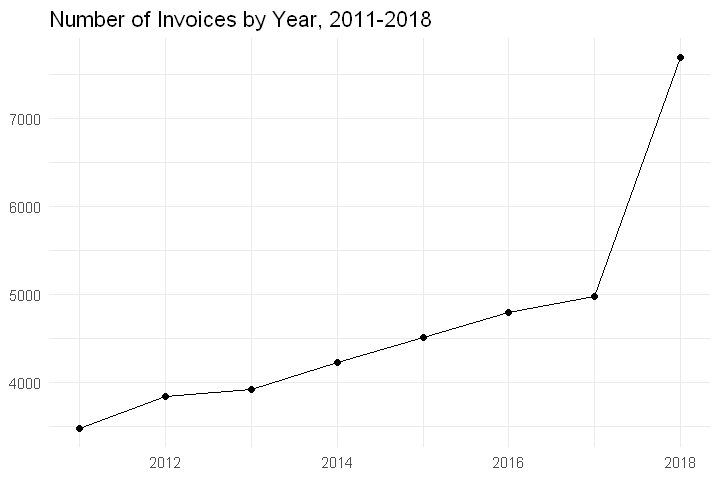

In [4]:
options(repr.plot.width=6, repr.plot.height=4)
itemsByYear <- lineItems %>% group_by(CalendarYear) %>% summarize(n = n())
ggplot(data = itemsByYear, aes(x = CalendarYear, y = n)) +
    geom_point() +
    geom_line() +
    theme_minimal() +
    labs(x = NULL, y = NULL, title = "Number of Invoices by Year, 2011-2018")

## Breakdowns by Time

One way that we can slice cohorts of data is by time.  For example, we can look at monthly invoice counts on a year-by-year basis to gain an understanding of behavior.  We can use a box plot to visualize counts by month for each year.

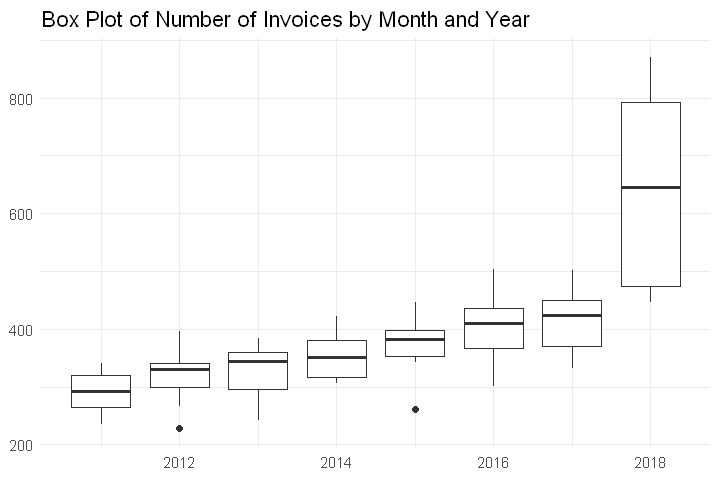

In [5]:
itemsByMonthAndYear <- lineItems %>% group_by(FirstDayOfMonth, CalendarYear, CalendarMonth) %>% summarize(n = n())
ggplot(data = itemsByMonthAndYear, aes(x = CalendarYear, y = n, group = CalendarYear)) +
    geom_boxplot() +
    theme_minimal() +
    labs(x = NULL, y = NULL, title = "Box Plot of Number of Invoices by Month and Year")

2018 has a **huge** spread compared to other years.  what's particularly interesting is that there are at least two months in the data set where the number of invoices is about what we'd expect given the general trend.

I can then lay out month on a scatter plot to make this even clearer.

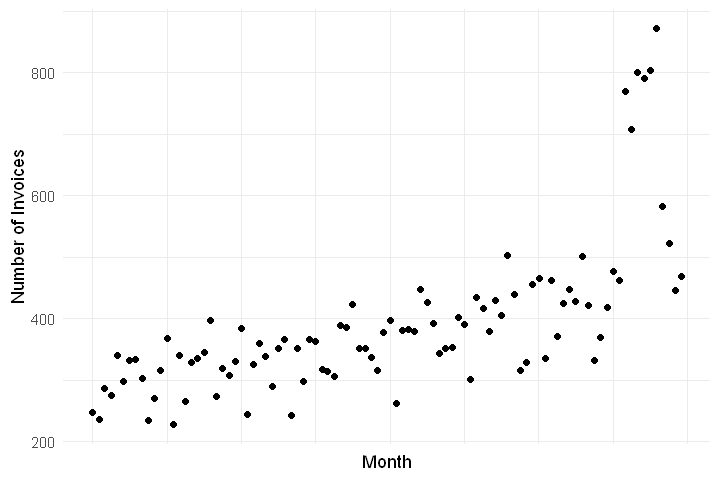

In [6]:
ggplot(data = itemsByMonthAndYear, aes(x = FirstDayOfMonth, y = n)) +
    geom_point() +
    theme_minimal() +
    labs(x = "Month", y = "Number of Invoices") +
    theme(axis.text.x = element_blank())

It looks like there are 7 months where behavior is abnormal and 7 years of normal behavior.  Looking solely at 2018, we can see which months exhibit this behavior.

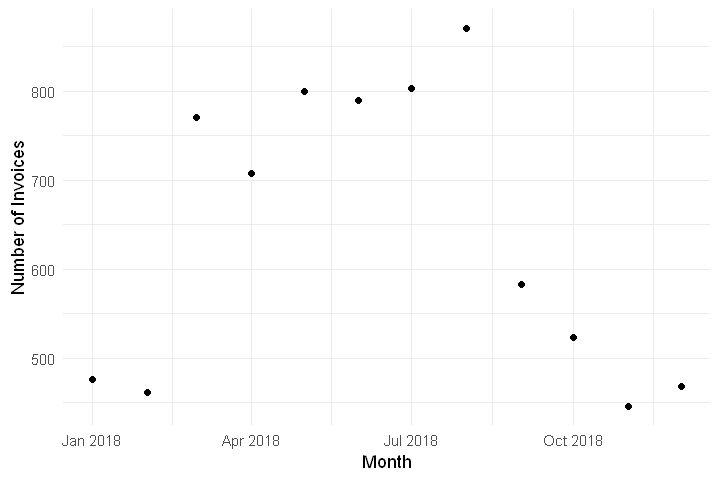

In [7]:
ggplot(data = filter(itemsByMonthAndYear, CalendarYear == 2018), aes(x = FirstDayOfMonth, y = n)) +
    geom_point() +
    scale_x_date() +
    theme_minimal() +
    labs(x = "Month", y = "Number of Invoices")

It looks like this behavior kicked up in March and began to taper off in September.  We should keep this in mind as we analyze further.  Maybe there was something big happening in spring and summer of 2018 which required more vehicle maintenance?  Before we tip our hand, let's continue to do more research.

## Breakdowns by Expense Category

Let's move over to expense categories and see what those look like.

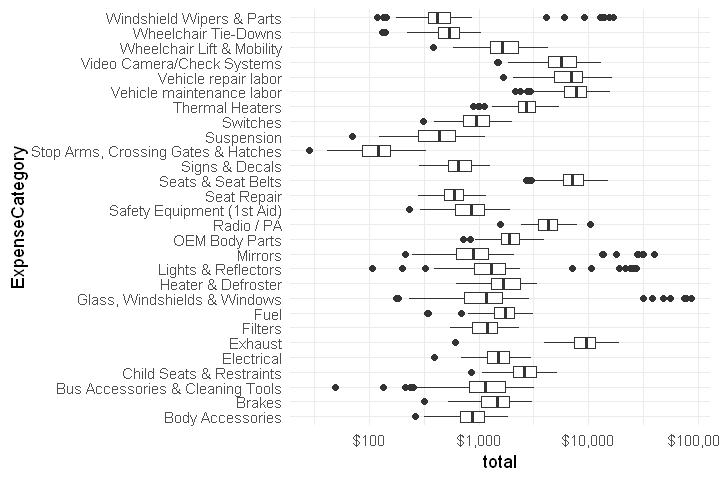

In [8]:
expenseCategoriesByMonth <- lineItems %>%
    group_by(ExpenseCategory, FirstDayOfMonth, CalendarMonth, CalendarYear) %>%
    summarize(n = n(), total = sum(Amount), avg = mean(Amount))

ggplot(data = expenseCategoriesByMonth, aes(x = ExpenseCategory, y = total)) +
    geom_boxplot() +
    scale_y_continuous(trans = "log10", labels = scales::dollar) +
    coord_flip() +
    theme_minimal()

There are a few categories with a lot of high-end amounts per month, primiarly around windshields.  Let's look at the mean invoice amount.

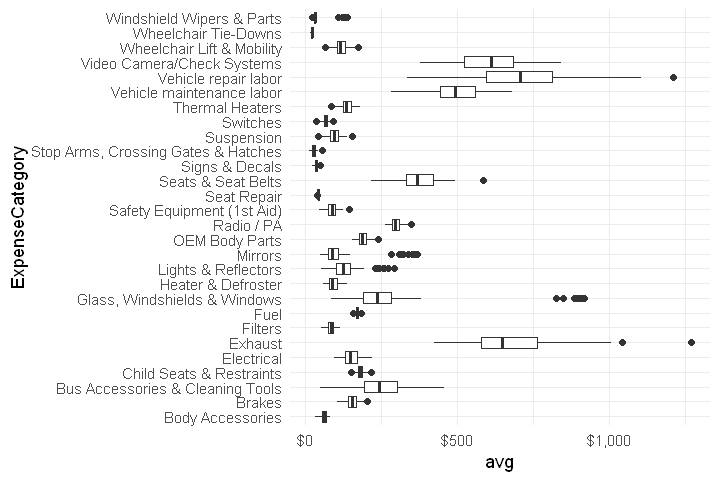

In [9]:
ggplot(data = expenseCategoriesByMonth, aes(x = ExpenseCategory, y = avg)) +
    geom_boxplot() +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    theme_minimal()

Not much new information here.  How about we compare vendor 5 versus other vendors in the Glass, Windshields, and Windows category.

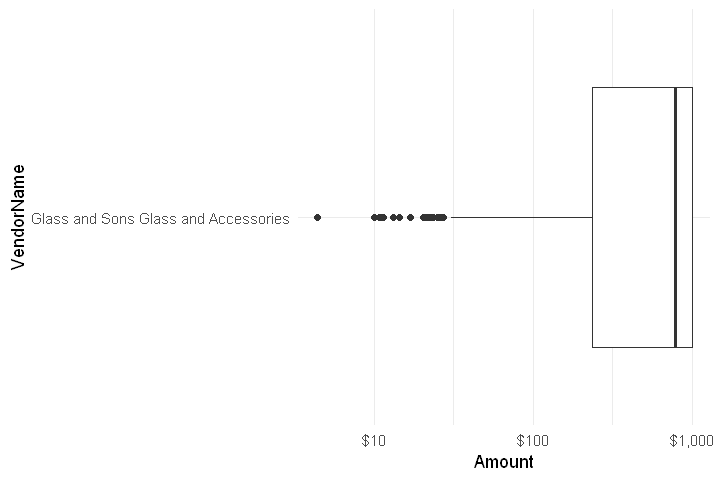

In [10]:
ggplot(data = filter(lineItems, ExpenseCategory == "Glass, Windshields & Windows"), aes(x = VendorName, y = Amount)) +
    geom_boxplot() +
    scale_y_continuous(trans = "log10", labels = scales::dollar) +
    coord_flip() +
    theme_minimal()

Well, that's interesting:  vendor 5 (Glass and Sons Glass and Accessories) is the only seller for this product category.

## Investigating Glass and Sons

Let's use faceting to look at all four categories that Glass and Sons work with:  4, 8, 18, and 19.  We'll start with all years earlier than 2018.

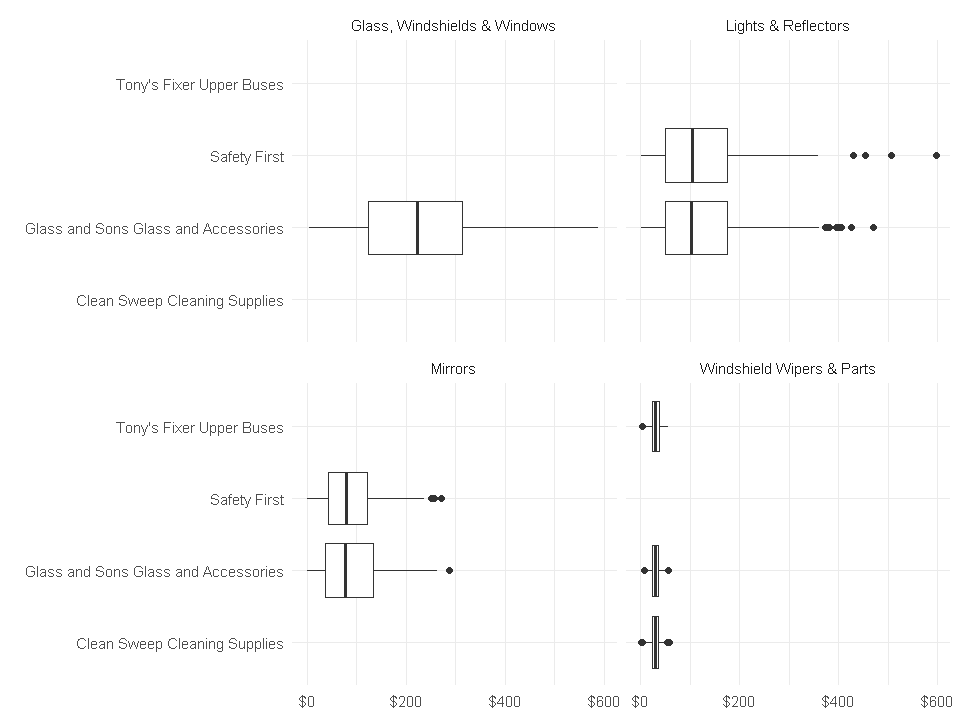

In [11]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = filter(lineItems, ExpenseCategoryID %in% c(4, 8, 18, 19) & CalendarYear < 2018),
       aes(x = VendorName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal() +
    facet_wrap(facets = ~ExpenseCategory, ncol = 2)

Glass and Sons seems like they are right in line with other vendors and the average for Glass, Windshields & Windows is about \$200 a pop.  In addition, the number of invoices for each is pretty similar--we can tell because we set `varwidth = TRUE` and the plots are about the same size.  Now let's look at 2018 for comparison.

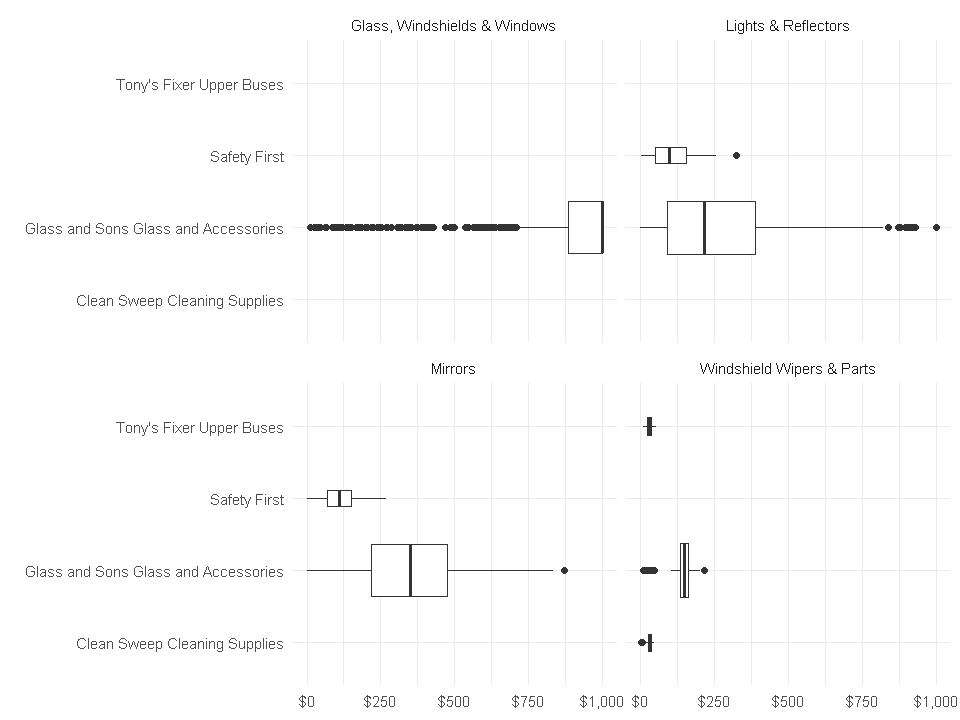

In [12]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = filter(lineItems, ExpenseCategoryID %in% c(4, 8, 18, 19) & CalendarYear == 2018),
       aes(x = VendorName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal() +
    facet_wrap(facets = ~ExpenseCategory, ncol = 2)

Notice that Glass and Sons has become consistently more expensive than the alternatives.  Despite them being consistently and considerably more expensive, the county is using this vendor several times more than the alternatives.  That's not normal behavior.


## Analyzing Employees

We don't have incredibly strong evidence of foul play but we do have the start:  abnormal behavior leading to major increases in expenditures.  And it's not like market circumstances have driven the changes:  the other players in the market are still doing their thing and charging about the same price as they historically have.  If there is fraud, we would expect to see at least one person on the inside behaving differently.  This is where cohort analysis really shines.  First, we'll create a box plot (without ggplot2 to show you that yes, it can be done) to look at the dollar amounts different employees handle in their invoices. 

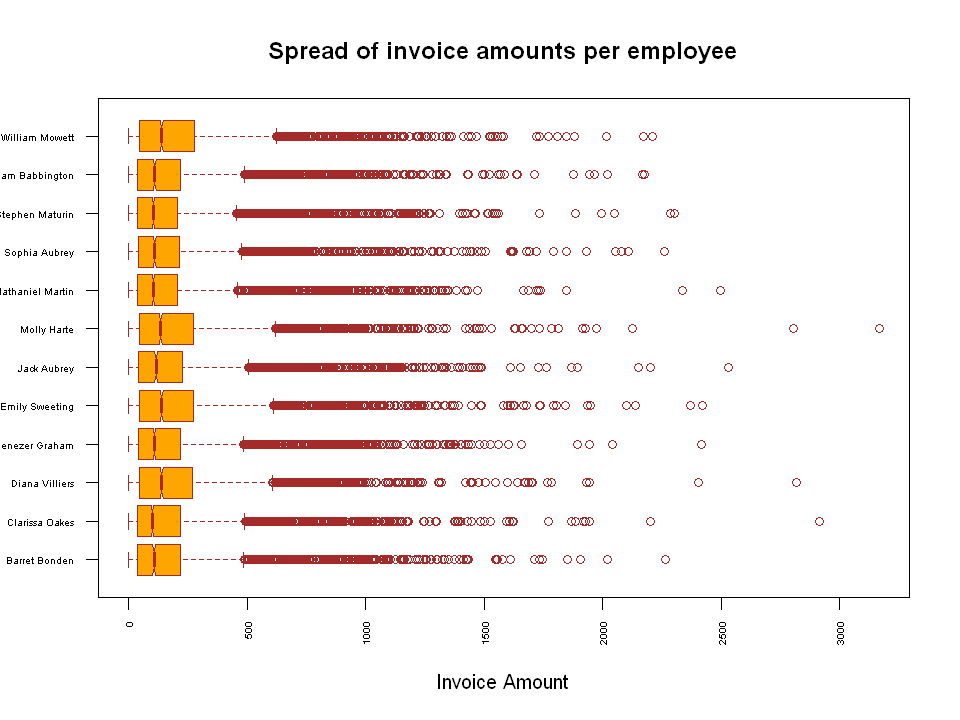

In [13]:
options(repr.plot.width=8, repr.plot.height=6)
par(cex.axis=0.5) 
boxplot(Amount ~ EmployeeName,
    data = lineItems,
    main = "Spread of invoice amounts per employee",
    xlab = "Invoice Amount",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE,
    las = 2
)

On the whole, these are pretty similar.  A few people are higher than the others but it doesn't look absurd here.  Let's focus now on Glass and Sons invoices for pre-2018 and 2018.  First the pre-2018 data:

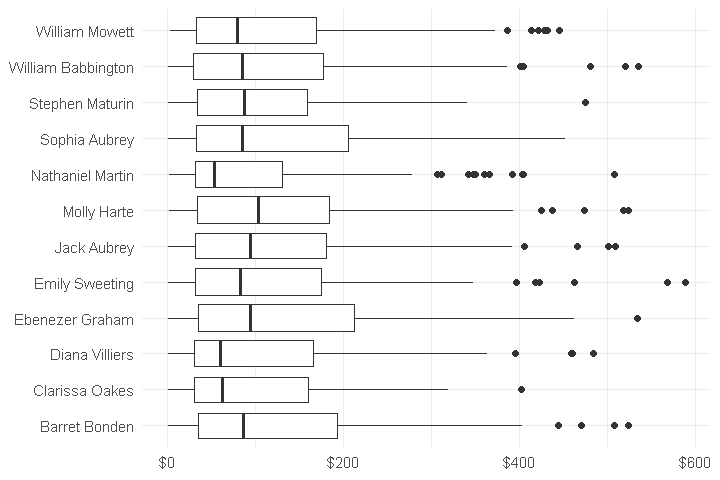

In [14]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID == 5 & CalendarYear < 2018),
       aes(x = EmployeeName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal()

As we would expect, there are some differences and everybody has a spread, but nobody really stands out.  Now let's look at the year 2018.

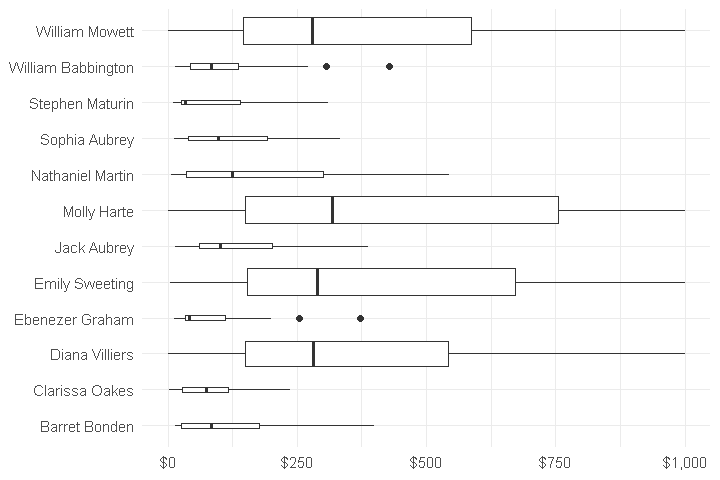

In [15]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID == 5 & CalendarYear == 2018),
       aes(x = EmployeeName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal()

This is **quite** different behavior.  Eight of our 12 employees are still acting normally throughout the year, but four employees have much higher averages and many, many more invoices.  Let's go a step further and compare the 7 months with extended sales versus 5 months with normal sales.  I'm counting September as extended and October as not extended, though there's some fuzziness there.

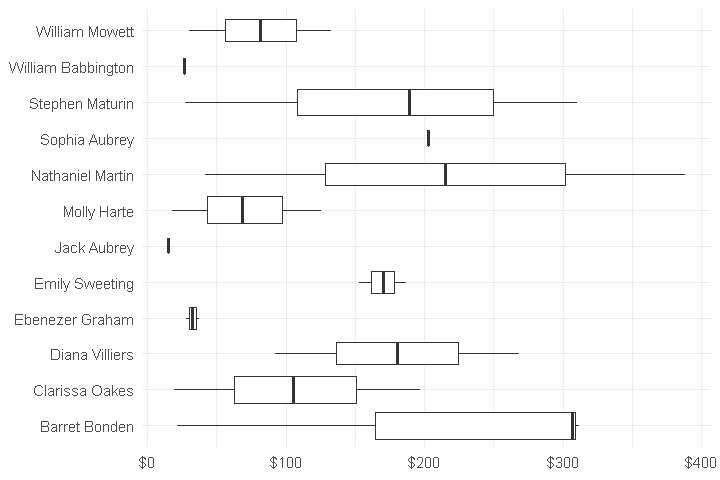

In [16]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID == 5 & CalendarYear == 2018 & CalendarMonth %in% 1,2,10,11,12),
       aes(x = EmployeeName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal()

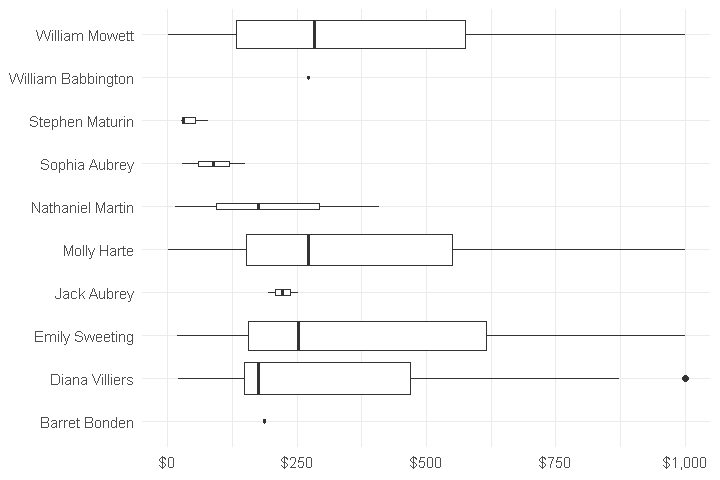

In [17]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID == 5 & CalendarYear == 2018 & CalendarMonth %in% 3,4,5,6,7,8,9),
       aes(x = EmployeeName, y = Amount)) +
    geom_boxplot(varwidth = TRUE) +
    scale_y_continuous(labels = scales::dollar) +
    coord_flip() +
    labs(y = NULL, x = NULL) +
    theme_minimal()

Notice that all of the difference is wrapped up in those months and limited to four people.  These are now persons of interest and we're starting to get evidence of a plot.  There may still be a valid explanation for this but it's a bit harder to believe when 8 of the 12 employees handling invoices didn't change their behaviors over this time frame.

## Clustering Behavior

One last area of investigation is clustering behavior.  We want to see if there are clusters of invoice amounts in our data set.  Knowing that \$1000 is the point where we need two signatures, we want to see what pricing distributions look like.

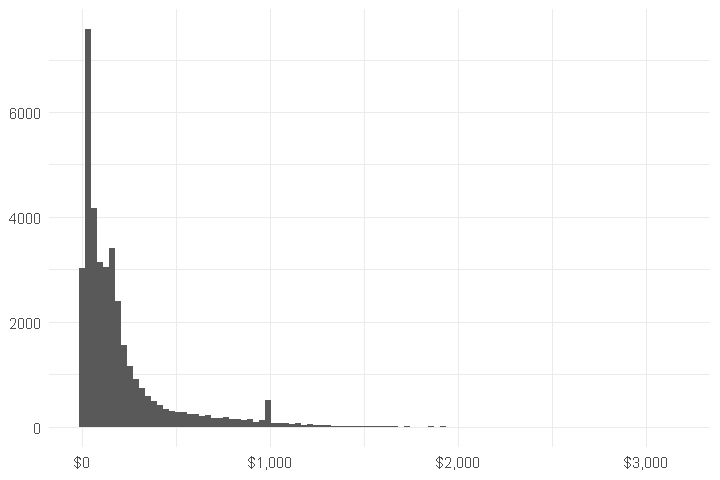

In [18]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems), aes(x = Amount)) +
    geom_histogram(bins = 100) +
    scale_x_continuous(labels = scales::dollar) +
    labs(y = NULL, x = NULL) +
    theme_minimal()

There is a gradual downward curve but then a bump right around the \$1000 mark.  Let's separate Glass and Sons from the rest of the set to see how they look.  First Glass and Sons:

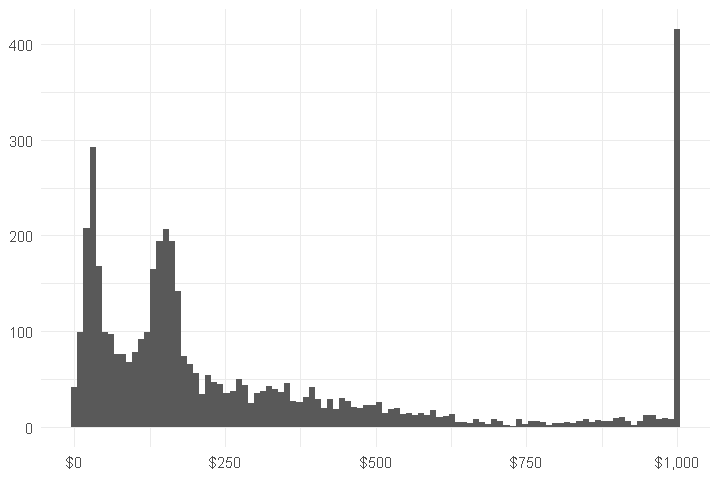

In [19]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID == 5), aes(x = Amount)) +
    geom_histogram(bins = 100) +
    scale_x_continuous(labels = scales::dollar) +
    labs(y = NULL, x = NULL) +
    theme_minimal()

And everybody else:

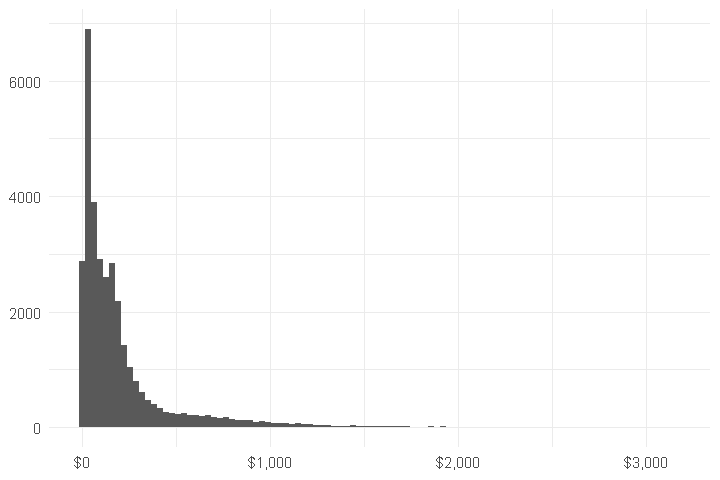

In [20]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = filter(lineItems, VendorID != 5), aes(x = Amount)) +
    geom_histogram(bins = 100) +
    scale_x_continuous(labels = scales::dollar) +
    labs(y = NULL, x = NULL) +
    theme_minimal()

This makes Glass and Sons look even more suspicious.  The multiple peaks at the beginning of the data set are something we can explain:  they sell in different categories with different price points, so there won't necessarily be one smooth curve.  But the massive jut at just under \$1K?  Yeah, that's weird.